In [19]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
IMG_SIZE = (128, 128)
DATA_DIR = "Dataset/preprocessed_images"
META_CSV = "Dataset/meta_train.csv"
SEED = 42
EPOCHS = 30
BATCH_SIZE = 32

import random
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

meta_df = pd.read_csv(META_CSV)
le = LabelEncoder()
meta_df["variety_encoded"] = le.fit_transform(meta_df["variety"])
num_classes = len(le.classes_)

In [21]:
X, y = [], []
for _, row in meta_df.iterrows():
    try:
        img_id = row["image_id"].replace(".jpg", "")
        label = row["label"]
        img_path = os.path.join(DATA_DIR, label, img_id + "_nipy_spectral.jpg")
        img = load_img(img_path, target_size=IMG_SIZE, color_mode="grayscale")
        img = img_to_array(img) / 255.0
        img = np.repeat(img, 3, axis=-1)
        X.append(img)
        y.append(row["variety_encoded"])
    except FileNotFoundError:
        continue

X = np.array(X)
y = to_categorical(y, num_classes=num_classes)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

In [23]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True
)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    callbacks=[early_stop]
)

Epoch 1/30
261/261 [==============================] - 26s 97ms/step - loss: 1.2564 - accuracy: 0.6776 - val_loss: 1.9642 - val_accuracy: 0.4443
Epoch 2/30
261/261 [==============================] - 25s 96ms/step - loss: 1.1428 - accuracy: 0.6930 - val_loss: 1.2548 - val_accuracy: 0.5735
Epoch 3/30
261/261 [==============================] - 25s 95ms/step - loss: 1.0666 - accuracy: 0.6996 - val_loss: 1.6380 - val_accuracy: 0.5000
Epoch 4/30
261/261 [==============================] - 25s 96ms/step - loss: 0.9940 - accuracy: 0.7094 - val_loss: 1.4975 - val_accuracy: 0.5346
Epoch 5/30
261/261 [==============================] - 25s 96ms/step - loss: 0.9319 - accuracy: 0.7130 - val_loss: 1.0077 - val_accuracy: 0.6604
Epoch 6/30
261/261 [==============================] - 25s 96ms/step - loss: 0.9022 - accuracy: 0.7219 - val_loss: 1.3390 - val_accuracy: 0.5821
Epoch 7/30
261/261 [==============================] - 25s 96ms/step - loss: 0.8707 - accuracy: 0.7252 - val_loss: 0.8579 - val_accuracy:

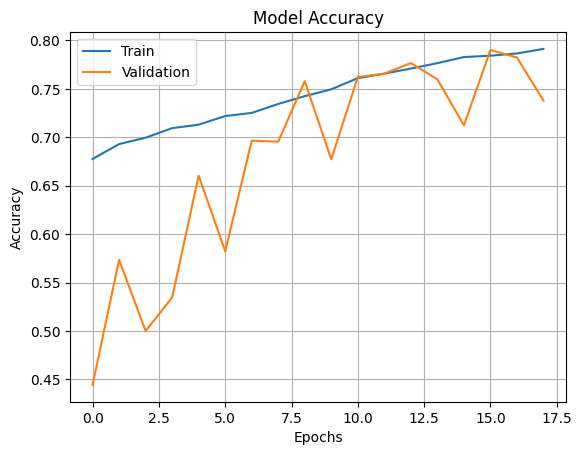

In [25]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
model.save("spectral_only_model.keras")

In [27]:
TEST_DIR = "Dataset/preprocessed_test_images"
all_files = os.listdir(TEST_DIR)
image_ids = sorted(set(f.split("_")[0] for f in all_files if f.endswith("_nipy_spectral.jpg")))

results = []
for img_id in image_ids:
    try:
        path = os.path.join(TEST_DIR, img_id + "_nipy_spectral.jpg")
        img = load_img(path, target_size=IMG_SIZE, color_mode="grayscale")
        img = img_to_array(img) / 255.0
        img = np.repeat(img, 3, axis=-1)
        img = np.expand_dims(img, axis=0)

        pred = model.predict(img, verbose=0)
        predicted_variety = le.classes_[np.argmax(pred)]
        results.append({"image_id": img_id + ".jpg", "label": "", "variety": predicted_variety})
    except Exception as e:
        print(f"Skipping {img_id}: {e}")

In [28]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

acc = accuracy_score(y_true_labels, y_pred_labels)
print("Accuracy on test set:", acc)

66/66 [==============================] - 1s 9ms/step
Accuracy on test set: 0.776657060518732


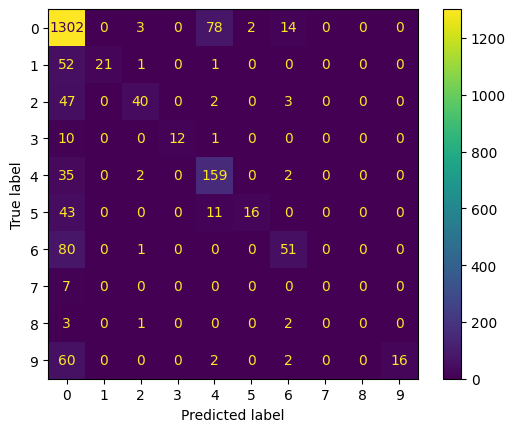

In [29]:
cm = confusion_matrix(y_true_labels, y_pred_labels)
ConfusionMatrixDisplay(cm).plot()